# **Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
from keras.preprocessing import text,sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout






## **Load and Check Data**

In [ ]:
real_data = pd.read_csv("/content/True.csv")
fake_data = pd.read_csv("/content/Fake.csv")

In [ ]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
#add column
real_data['target'] = 1
fake_data['target'] = 0

In [ ]:
real_data.tail()

,title,text,subject,date,target
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",1


In [ ]:
#Merging the 2 datasets
data = pd.concat([real_data, fake_data], ignore_index=True, sort=False)
data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

## **Visualization**

**1.Count of Fake and Real Data**

0    23481
1    21417
Name: target, dtype: int64


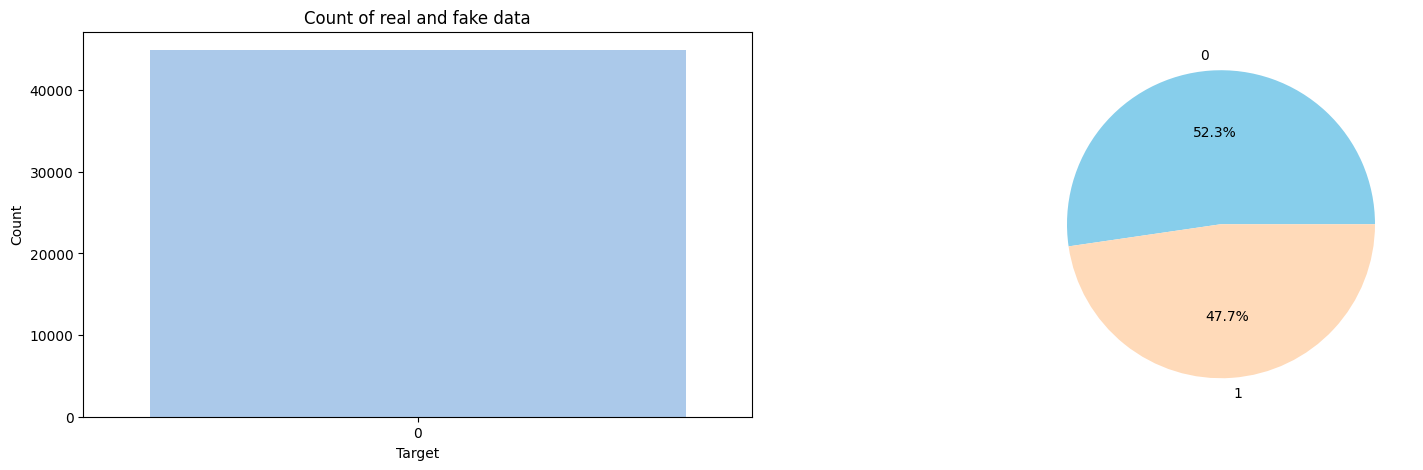

In [ ]:
print(data["target"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(data.target,ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("Target")
g2 = plt.pie(data["target"].value_counts().values,explode=[0,0],labels=data.target.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()

**2.Distribution of The Subject According to Real and Fake Data**

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64


Text(0.5, 1.0, 'Distribution of The Subject According to Real and Fake Data')

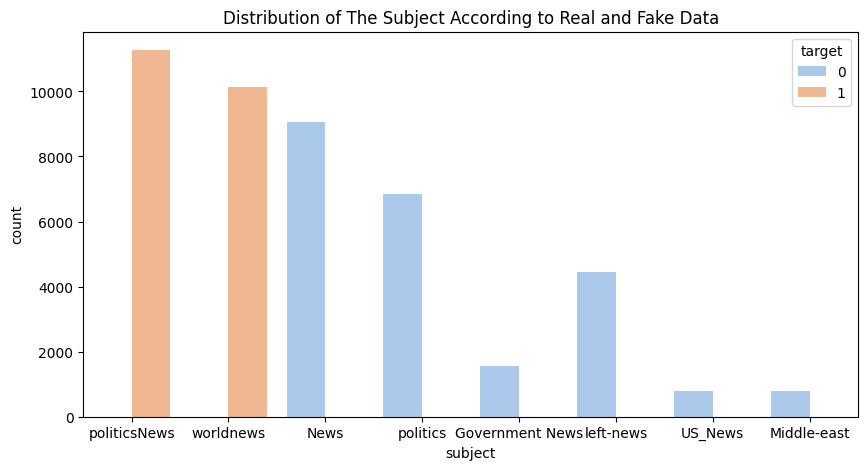

In [ ]:
print(data.subject.value_counts())
plt.figure(figsize=(10, 5))

ax = sns.countplot(x="subject",  hue='target', data=data, palette="pastel")
plt.title("Distribution of The Subject According to Real and Fake Data")

## **Data Cleaning**

In [ ]:
data['text']= data['subject'] + " " + data['title'] + " " + data['text']
del data['title']
del data['subject']
del data['date']
data.head()

,text,target
0,"politicsNews As U.S. budget fight looms, Repub...",1
1,politicsNews U.S. military to accept transgend...,1
2,politicsNews Senior U.S. Republican senator: '...,1
3,politicsNews FBI Russia probe helped by Austra...,1
4,politicsNews Trump wants Postal Service to cha...,1


In [ ]:
first_text = data.text[10]
first_text

'politicsNews Jones certified U.S. Senate winner despite Moore challenge (Reuters) - Alabama officials on Thursday certified Democrat Doug Jones the winner of the state’s U.S. Senate race, after a state judge denied a challenge by Republican Roy Moore, whose campaign was derailed by accusations of sexual misconduct with teenage girls. Jones won the vacant seat by about 22,000 votes, or 1.6 percentage points, election officials said. That made him the first Democrat in a quarter of a century to win a Senate seat in Alabama.  The seat was previously held by Republican Jeff Sessions, who was tapped by U.S. President Donald Trump as attorney general. A state canvassing board composed of Alabama Secretary of State John Merrill, Governor Kay Ivey and Attorney General Steve Marshall certified the election results. Seating Jones will narrow the Republican majority in the Senate to 51 of 100 seats. In a statement, Jones called his victory “a new chapter” and pledged to work with both parties. M

## **Removal of HTML Contents**

In [ ]:
pip install bs4

In [ ]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(first_text, "html.parser")
first_text = soup.get_text()
first_text

'politicsNews Jones certified U.S. Senate winner despite Moore challenge (Reuters) - Alabama officials on Thursday certified Democrat Doug Jones the winner of the state’s U.S. Senate race, after a state judge denied a challenge by Republican Roy Moore, whose campaign was derailed by accusations of sexual misconduct with teenage girls. Jones won the vacant seat by about 22,000 votes, or 1.6 percentage points, election officials said. That made him the first Democrat in a quarter of a century to win a Senate seat in Alabama.  The seat was previously held by Republican Jeff Sessions, who was tapped by U.S. President Donald Trump as attorney general. A state canvassing board composed of Alabama Secretary of State John Merrill, Governor Kay Ivey and Attorney General Steve Marshall certified the election results. Seating Jones will narrow the Republican majority in the Senate to 51 of 100 seats. In a statement, Jones called his victory “a new chapter” and pledged to work with both parties. M

## **Removal of Punctuation Marks and Special Character**

**Remove everything except uppercase / lowercase letters using Regular Expressions.**

In [ ]:
first_text = re.sub('\[[^]]*\]', ' ', first_text)
first_text = re.sub('[^a-zA-Z]',' ',first_text)  # replaces non-alphabets with spaces
first_text = first_text.lower() # Converting from uppercase to lowercase
first_text

'politicsnews jones certified u s  senate winner despite moore challenge  reuters    alabama officials on thursday certified democrat doug jones the winner of the state s u s  senate race  after a state judge denied a challenge by republican roy moore  whose campaign was derailed by accusations of sexual misconduct with teenage girls  jones won the vacant seat by about        votes  or     percentage points  election officials said  that made him the first democrat in a quarter of a century to win a senate seat in alabama   the seat was previously held by republican jeff sessions  who was tapped by u s  president donald trump as attorney general  a state canvassing board composed of alabama secretary of state john merrill  governor kay ivey and attorney general steve marshall certified the election results  seating jones will narrow the republican majority in the senate to    of     seats  in a statement  jones called his victory  a new chapter  and pledged to work with both parties  m

## **Removal of Stopwords**

### **Remove stopwords like is,a,the... Which do not offer much insight.**





In [ ]:
'''nltk.download("stopwords")
from nltk.corpus import stopwords

# we can use tokenizer instead of split
first_text = nltk.word_tokenize(first_text)'''

SyntaxError: ignored

In [ ]:
import nltk
from nltk.corpus import stopwords  # Import the stopwords module

# Download the 'stopwords' resource
nltk.download('stopwords')

# Assuming first_text is not a string but a list of words
first_text = ["This", "is", "a", "sample", "text"]

# Join the list of words into a string
first_text_str = " ".join(first_text)

# Now you can use word_tokenize
tokens = nltk.word_tokenize(first_text_str)

# Print the tokens
print(tokens)

# Now filter out stopwords
filtered_text = [word for word in tokens if word.lower() not in set(stopwords.words("english"))]
print(filtered_text)


['This', 'is', 'a', 'sample', 'text']
['sample', 'text']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
first_text = [ word for word in first_text if not word in set(stopwords.words("english"))]

## **Lemmatization**

**Lemmatization to bring back multiple forms of same word to their common root like 'coming', 'comes' into 'come'.**

In [ ]:
lemma = nltk.WordNetLemmatizer()
first_text = [ lemma.lemmatize(word) for word in first_text]

first_text = " ".join(first_text)
first_text

'This sample text'

In [ ]:
import nltk

# Download the 'wordnet' resource
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Perform it for all the examples.

We performed the steps for a single example. Now let's perform it for all the examples in the data.

In [ ]:
'''#Removal of HTML Contents
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removal of Punctuation Marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

# Removal of Special Characters
def remove_characters(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)

    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word)
            final_text.append(word)
    return " ".join(final_text)

#Total function
def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

#Apply function on text column
data['text']=data['text'].apply(cleaning)'''

KeyboardInterrupt: ignored

In [ ]:
from tqdm import tqdm

# Removal of HTML Contents
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removal of Punctuation Marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

# Removal of Special Characters
def remove_characters(text):
    return re.sub("[^a-zA-Z]"," ",text)

# Removal of stopwords
def remove_stopwords_and_lemmatization(text):
    stop_words = set(stopwords.words('english'))
    lemma = nltk.WordNetLemmatizer()
    final_text = []

    for word in tqdm(nltk.word_tokenize(text), desc="Processing words"):
        if word.lower() not in stop_words:
            word = lemma.lemmatize(word)
            final_text.append(word)

    return " ".join(final_text)

# Total function
def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

# Apply function on the 'text' column
data['text'] = data['text'].apply(cleaning)

Streaming output truncated to the last 5000 lines.
Processing words: 100%|██████████| 913/913 [00:00<00:00, 176600.24it/s]


In [ ]:
data.head()

,text,target
0,politicsNews U budget fight loom Republicans f...,1
1,politicsNews U military accept transgender rec...,1
2,politicsNews Senior U Republican senator Let M...,1
3,politicsNews FBI Russia probe helped Australia...,1
4,politicsNews Trump want Postal Service charge ...,1


<h2><b>Visualization with new data.</b></h2>

<h3><b>1.WordCloud for Real News </b></h3>

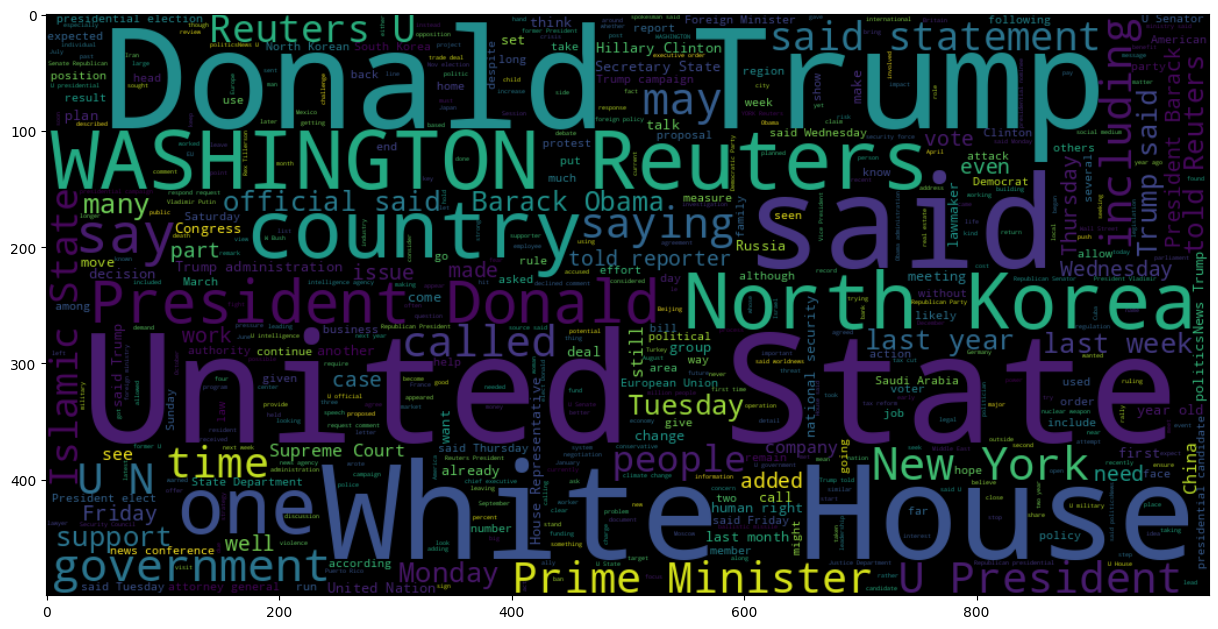

In [ ]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.target == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

<h3><b>2.WordCloud for Fake News </b></h3>

In [ ]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.target == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

<h3><b>Number of words in each text</b></h3>

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('Fake news text')
text_len=data[data['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='PeachPuff')
ax2.set_title('Real news text')
fig.suptitle('Words in texts')
plt.show()

**The number of words seems to be a bit different. 500 words  are most common in real news category while around 250 words are most common in fake news category.**

## **N-Gram Analysis**

In [ ]:
texts = ' '.join(data['text'])

In [ ]:
string = texts.split(" ")

In [ ]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (16,9))
    return sns.barplot(x='count',y='word', data=n_gram_df)

### **Unigram Analysis**

In [ ]:
draw_n_gram(string,1)

### **Bigram Analysis**

In [ ]:
draw_n_gram(string,2)

### **Trigram Analysis**

In [ ]:
draw_n_gram(string,3)

## **Models**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], random_state=0)

## **Tokenizing**

* **Tokenizing Text -> Repsesenting each word by a number**

* **Mapping of orginal word to number is preserved in word_index property of tokenizer**

<h3><b>Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones </b></h3>

In [ ]:
max_features = 10000
maxlen = 300

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

## **Training LSTM Model**

In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))
#LSTM
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

## **Analysis After Training **

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

In [ ]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
pred = model.predict_classes(X_test)
print(classification_report(y_test, pred, target_names = ['Fake','Real']))